In [1]:
"""
Discriminator and Generator implementation from DCGAN paper
Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
* 2020-11-01: Initial coding
* 2022-12-20: Small revision of code, checked that it works with latest PyTorch version
"""

'\nDiscriminator and Generator implementation from DCGAN paper\nProgrammed by Aladdin Persson <aladdin.persson at hotmail dot com>\n* 2020-11-01: Initial coding\n* 2022-12-20: Small revision of code, checked that it works with latest PyTorch version\n'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from tqdm import tqdm


In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Discriminator, self).__init__()
        self.img_size= img_size
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img+1, features_d, kernel_size=4, stride=2, padding=1),# 32x32
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1), # 16x16
            self._block(features_d * 2, features_d * 4, 4, 2, 1), # 8x8
            self._block(features_d * 4, features_d * 8, 4, 2, 1), # 4x4
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0), # 1x1
            nn.Sigmoid(),
        )
        self.embed=nn.Embedding(num_classes, img_size*img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x, labels):
        embedding= self.embed(labels).view(labels.shape[0], 1, self.img_size,self.img_size)
        x=torch.cat([x, embedding], dim=1)
        return self.disc(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes,img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size=img_size
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1, in this case its 100
            self._block(channels_noise+embed_size, features_g * 16, 4, 1, 0),  # img: 4x4, chanel size 64*16 = 1024 as per paper
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8,chanel size 64*8 = 512 as per paper
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16, chanel size 64*4 = 256 as per paper
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32, chanel size 64*2 = 128 as per paper
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64, in mnist case its 1
            nn.Tanh(),
        )
        self.embed=nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x, labels):
        #latent vector z:N x noice_dim x 1 x 1
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x=torch.cat([x, embedding], dim=1)
        return self.net(x)

In [9]:
def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [5]:
# Testing Dicrimanator and generator code

def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    assert disc(x).shape == (N, 1, 1, 1), "Discriminator test failed"
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W), "Generator test failed"
    print("Success, tests passed!")


test()

TypeError: __init__() missing 2 required positional arguments: 'num_classes' and 'img_size'

In [6]:
# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 1 #for mnist gray scale dataset
NUM_CLASSES=10
GEN_EMBEDDING=100
NOISE_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64

transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [7]:
# If you train on MNIST, remember to set channels_img to 1
dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms, download=True
)

# comment mnist above and uncomment below if train on Celeb
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [42]:

tt=enumerate(dataloader)

ii,(xx,yy)= next(tt)
print(xx.shape)
print(yy.shape)
yy

torch.Size([128, 1, 64, 64])
torch.Size([128])


tensor([0, 5, 9, 4, 0, 2, 7, 0, 3, 2, 6, 5, 5, 3, 7, 3, 1, 8, 6, 9, 3, 6, 9, 8,
        5, 1, 4, 5, 0, 6, 5, 0, 2, 9, 4, 3, 5, 3, 8, 7, 3, 1, 9, 5, 1, 0, 3, 1,
        4, 4, 6, 1, 1, 2, 5, 8, 7, 9, 5, 8, 4, 5, 6, 6, 0, 2, 0, 8, 6, 8, 0, 7,
        7, 5, 3, 3, 6, 6, 5, 5, 9, 2, 2, 3, 4, 9, 3, 7, 9, 0, 2, 7, 1, 0, 5, 3,
        2, 5, 9, 0, 6, 5, 3, 8, 1, 2, 8, 9, 1, 5, 4, 3, 5, 7, 9, 5, 6, 1, 1, 7,
        7, 0, 1, 2, 9, 6, 8, 2])

In [39]:
x=torch.randint(low=0, high=10, size=[128])
x

tensor([4, 3, 2, 2, 6, 0, 9, 5, 2, 6, 7, 6, 5, 3, 9, 8, 8, 0, 4, 3, 6, 7, 1, 5,
        9, 7, 6, 1, 8, 2, 8, 3, 6, 1, 4, 6, 6, 8, 2, 8, 7, 9, 0, 6, 7, 2, 2, 1,
        8, 6, 5, 5, 7, 4, 1, 0, 9, 2, 7, 7, 4, 4, 5, 1, 0, 8, 0, 5, 7, 8, 4, 0,
        3, 7, 5, 0, 7, 9, 9, 4, 1, 8, 4, 4, 4, 8, 8, 7, 2, 2, 5, 5, 4, 6, 7, 1,
        5, 5, 7, 2, 8, 2, 1, 5, 3, 5, 6, 0, 2, 5, 7, 0, 0, 2, 7, 4, 3, 4, 0, 3,
        8, 7, 8, 9, 0, 6, 3, 9])

In [10]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMAGE_SIZE,GEN_EMBEDDING).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC,NUM_CLASSES, IMAGE_SIZE).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [11]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()



In [63]:
fixed_noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
fixed_noise_labels=torch.randint(low=0, high=10, size=[BATCH_SIZE]).to(device)
fake2 = gen(fixed_noise,fixed_noise_labels)
fake2.shape


torch.Size([128, 1, 64, 64])

In [51]:
def show_image(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy() # convert from tensor
    figure(figsize=(15, 6), dpi=80)
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #Convert (3,32,32) to (32,32,3)
    plt.show()

# show_image(torchvision.utils.make_grid(images))

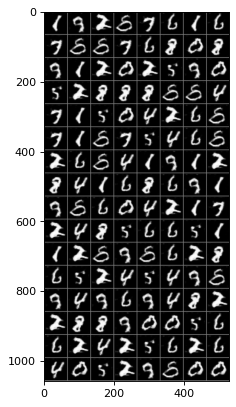

In [64]:
show_image(torchvision.utils.make_grid(fake2.cpu()))

  0%|          | 1/469 [00:00<05:17,  1.47it/s]

Epoch [0/10] Batch 0/469                   Loss D: 0.4926, loss G: 1.0008


100%|██████████| 469/469 [02:11<00:00,  3.57it/s]


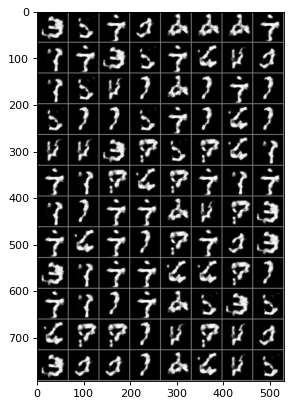

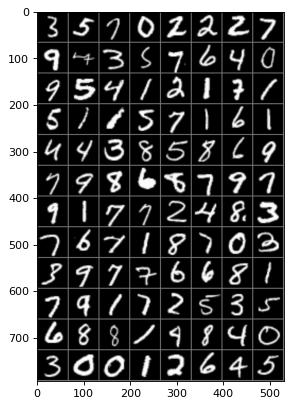

  0%|          | 1/469 [00:00<02:26,  3.18it/s]

Epoch [1/10] Batch 0/469                   Loss D: 0.5434, loss G: 1.6902


100%|██████████| 469/469 [02:15<00:00,  3.45it/s]


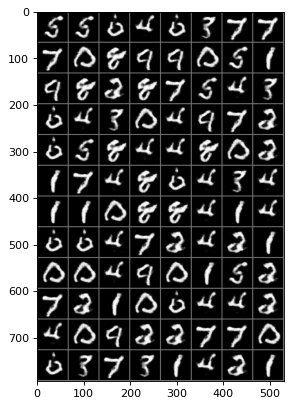

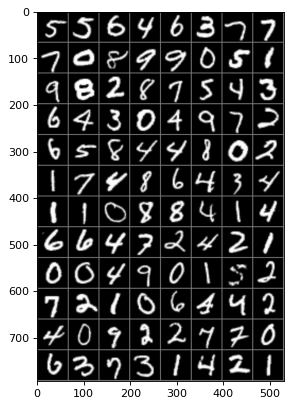

  0%|          | 1/469 [00:00<02:28,  3.15it/s]

Epoch [2/10] Batch 0/469                   Loss D: 0.3647, loss G: 1.5451


100%|██████████| 469/469 [02:19<00:00,  3.37it/s]


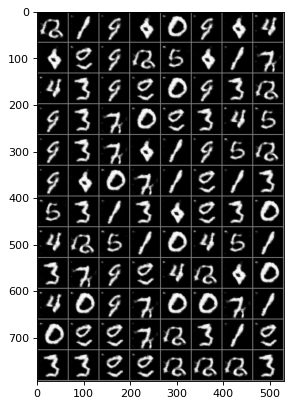

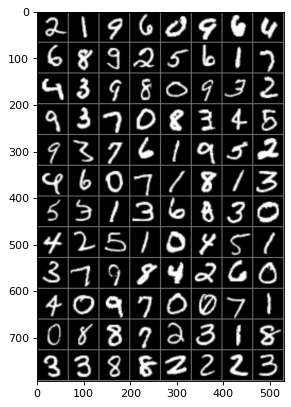

  0%|          | 1/469 [00:00<02:32,  3.07it/s]

Epoch [3/10] Batch 0/469                   Loss D: 0.2757, loss G: 2.1432


100%|██████████| 469/469 [02:33<00:00,  3.06it/s]


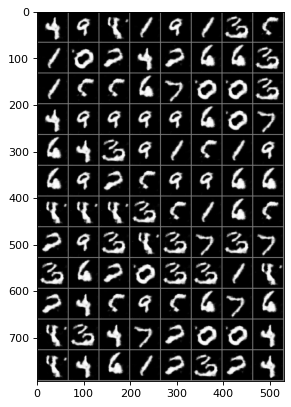

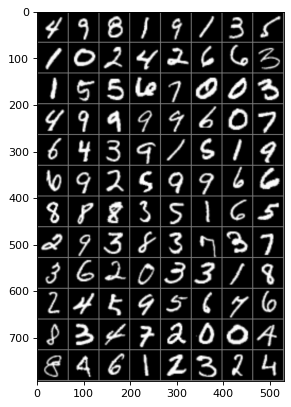

  0%|          | 1/469 [00:00<02:53,  2.69it/s]

Epoch [4/10] Batch 0/469                   Loss D: 0.3859, loss G: 3.3349


100%|██████████| 469/469 [02:44<00:00,  2.85it/s]


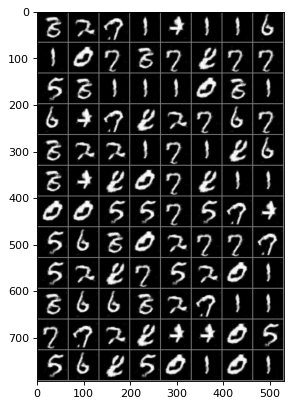

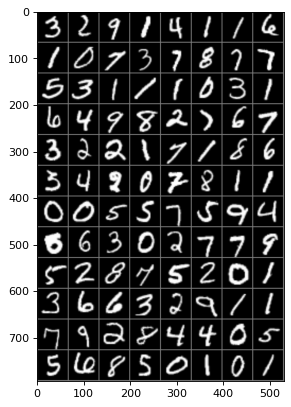

  0%|          | 1/469 [00:00<02:42,  2.89it/s]

Epoch [5/10] Batch 0/469                   Loss D: 0.3679, loss G: 2.0973


 52%|█████▏    | 246/469 [01:36<01:27,  2.55it/s]


KeyboardInterrupt: 

In [45]:
gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    
    for batch_idx, (real, labels) in enumerate(tqdm(dataloader)):
        real = real.to(device)
        labels=labels.to(device)
        
        noise = torch.randn(labels.size(0), NOISE_DIM, 1, 1).to(device)# cuz in the last bact we are only left with 96 labels in case of batch size 128
        fake = gen(noise,labels)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real, labels).view(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake, labels).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake, labels).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )
    
    with torch.no_grad():
        fake3= gen(noise, labels)
        show_image(torchvision.utils.make_grid(fake3.cpu()))
        show_image(torchvision.utils.make_grid(real.cpu()))